In [1]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia.feature.adalam import AdalamFilter
from kornia_moons.viz import *


device = K.utils.get_cuda_device_if_available()
print(device)

cpu


In [ ]:
feature_count = 4096

In [2]:
# %%capture
fname1 = "homography_dataset/img1.png"
fname2 = "homography_dataset/img5.png"

adalam_config = KF.adalam.get_adalam_default_config()
# adalam_config['orientation_difference_threshold'] = None
# adalam_config['scale_rate_threshold'] = None
adalam_config["force_seed_mnn"] = False
adalam_config["search_expansion"] = 16
adalam_config["ransac_iters"] = 256


img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32, device=device)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32, device=device)[None, ...]

disk = KF.DISK.from_pretrained("depth").to(device)

hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)

match_with_adalam = True

with torch.inference_mode():
    inp = torch.cat([img1, img2], dim=0)
    features1, features2 = disk(inp, feature_count, pad_if_not_divisible=True)
    
    kps1, descs1 = features1.keypoints, features1.descriptors
    kps2, descs2 = features2.keypoints, features2.descriptors
    if match_with_adalam:
        lafs1 = KF.laf_from_center_scale_ori(kps1[None], 96 * torch.ones(1, len(kps1), 1, 1, device=device))
        lafs2 = KF.laf_from_center_scale_ori(kps2[None], 96 * torch.ones(1, len(kps2), 1, 1, device=device))

        dists, idxs = KF.match_adalam(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2, config=adalam_config)
    else:
        dists, idxs = KF.match_smnn(descs1, descs2, 0.98)
        #dists, idxs = KF.match_mnn(descs1, descs2)


print(f"{idxs.shape[0]} tentative matches with DISK AdaLAM")

971 tentative matches with DISK AdaLAM


In [3]:
def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    return mkpts1, mkpts2


mkpts1, mkpts2 = get_matching_keypoints(kps1, kps2, idxs)

H, inliers = cv2.findHomography(
    mkpts1.detach().cpu().numpy(), mkpts2.detach().cpu().numpy(), cv2.USAC_ACCURATE
)  # , 1.0, 0.999, 100000
inliers = inliers > 0
print(f"{inliers.sum()} inliers with DISK")

426 inliers with DISK


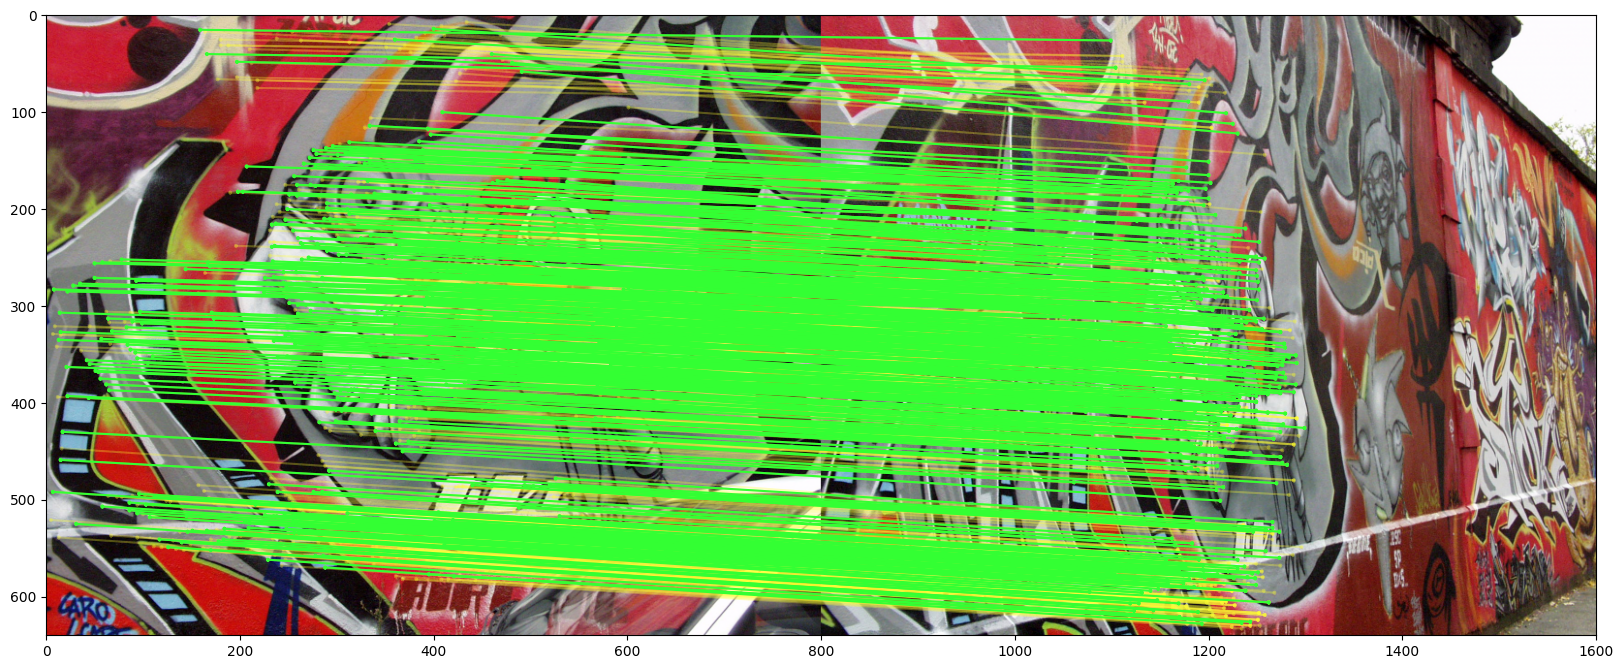

In [4]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(kps1[None].cpu()),
    KF.laf_from_center_scale_ori(kps2[None].cpu()),
    idxs.cpu(),
    K.tensor_to_image(img1.cpu()),
    K.tensor_to_image(img2.cpu()),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
)